In [ ]:
# 분석 환경 모듈
import numpy as np
import pandas as pd
import psycopg2 as pg
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style

# 데이터 분석 모듈
from CoolProp.CoolProp import PropsSI
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy.integrate import ode

# 내가 만든 모듈 임포트
from Model import *
from PhysicalProperty import *
from StructuredQuery import *
from Numeric import *

style.use('seaborn-talk')
krfont = {'family':'Times New Roman', 'weight':'bold', 'size':10}
matplotlib.rc('font', **krfont)
matplotlib.rcParams['axes.unicode_minus'] = False

In [ ]:
#############################################################
###################### CHF 계산 과정 ############################
#############################################################

sql = StructuredQuery()
pro = PhysicalProperty()
mod = ModelOSV()

In [ ]:
# CHF 데이터베이스 연결
# SQL 연결 쿼리문
(conn, db_engine) = sql.connect('localhost', 'Research', 'postgres', '5432', '1234')

# 연결 확인
print("PostgreSQL에 Research Database에 연결을 완료하였습니다.", conn)
print(db_engine)

# OSV 데이터베이스 연결
load_chf_query = "SELECT * FROM rawdata_chf_park_tb ORDER BY run_id LIMIT 2000" # Water CHF Table 10500개
#load_chf_query = "SELECT * FROM rawdata_chf_r12_tb" # R12 CHF Table 10500개
chf_tb = sql.read_sql(load_chf_query, db_engine)

In [ ]:
# Rawdata에서 Physical property 추가 (for water)
chf_tb['pcrit'] = round(chf_tb[['refri']].apply(lambda x: PropsSI(x[0],'pcrit') * 10**-5, axis=1),6) # [bar]
chf_tb['tsat'] = round(chf_tb[['p', 'refri']].apply(lambda x: PropsSI('T', 'P', x[0] * 1e5, 'Q', 0, x[1]), axis=1),6) # [K]
chf_tb['kf'] = round(chf_tb[['p', 'refri']].apply(lambda x: PropsSI('L', 'P', x[0] * 1e5, 'Q', 0, x[1]), axis=1),6) # [W/mK]
chf_tb['kv'] = round(chf_tb[['p', 'refri']].apply(lambda x: PropsSI('L', 'P', x[0] * 1e5, 'Q', 1, x[1]), axis=1),6) # [W/mK]
chf_tb['muf'] = round(chf_tb[['p', 'refri']].apply(lambda x: PropsSI('V', 'P', x[0] * 1e5, 'Q', 0, x[1]), axis=1),12) #  [Pa s]
chf_tb['muv'] = round(chf_tb[['p', 'refri']].apply(lambda x: PropsSI('V', 'P', x[0] * 1e5, 'Q', 1, x[1]), axis=1),12) # [Pa s]
chf_tb['hfo'] = round(chf_tb[['p', 'refri']].apply(lambda x: PropsSI('H', 'P', x[0] * 1e5, 'Q', 0, x[1]), axis=1),6) # [J/kgK]
chf_tb['hgo'] = round(chf_tb[['p', 'refri']].apply(lambda x: PropsSI('H', 'P', x[0] * 1e5, 'Q', 1, x[1]), axis=1),6) #[J/kgK]
chf_tb['lam'] = round(chf_tb['hgo'] - chf_tb['hfo'],6) # [J/kgK]
chf_tb['rhof'] = round(chf_tb[['p', 'refri']].apply(lambda x: PropsSI('D', 'P', x[0] * 1e5, 'Q', 0, x[1]), axis=1),6) #[kg/m3]
chf_tb['rhov'] = round(chf_tb[['p', 'refri']].apply(lambda x: PropsSI('D', 'P', x[0] * 1e5, 'Q', 1, x[1]), axis=1),6) # [kg/m3]
chf_tb['v'] = round(chf_tb['g'] / chf_tb['rhof'],6) # [m/s]
chf_tb['cpf'] = round(chf_tb[['p', 'refri']].apply(lambda x: PropsSI('C', 'P', x[0] * 1e5, 'Q', 0, x[1]), axis=1),6) # [J/kgK]
chf_tb['cpv'] = round(chf_tb[['p', 'refri']].apply(lambda x: PropsSI('C', 'P', x[0] * 1e5, 'Q', 1, x[1]), axis=1),6) # [J/kgK]
chf_tb['sigma'] = round(chf_tb[['p', 'refri']].apply(lambda x: PropsSI('I', 'P', x[0] * 1e5, 'Q', 0, x[1]), axis=1),6) # [N/m]
chf_tb['dtin'] = round(chf_tb[['degsubin', 'cpf', 'cpv']].apply(lambda x: x[0]*1e3/x[1] if x[0] > 0 else x[0]*1e3/x[2], axis=1),6)
chf_tb['rdcp'] = round(chf_tb['p']/chf_tb['pcrit'],6)

# Rawdata에서 Dimensionless number 추가
chf_tb['xi'] = round(chf_tb[['cpf', 'dtin', 'lam']].apply(lambda x: pro.calXi(x[0], x[1], x[2]), axis = 1),6)
chf_tb['xout'] = round(chf_tb[['q', 'doi', 'dio', 'geo', 'hsur', 'g', 'cpf', 'lam', 'dtin', 'lh']].apply(lambda x: pro.calXout(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9]), axis=1),6)
chf_tb['de'] = round(chf_tb[['doi', 'dio', 'geo', 'hsur', 'dh']].apply(lambda x: pro.calDe(x[0], x[1], x[2], x[3], x[4]), axis=1),6)
chf_tb['pe'] = round(chf_tb[['dh', 'g', 'cpf', 'kf']].apply(lambda x: pro.calPe(x[0], x[1], x[2], x[3]), axis=1),6)
chf_tb['re'] = round(chf_tb[['g', 'dh', 'muf']].apply(lambda x: pro.calRe(x[0], x[1], x[2]), axis=1),6)
chf_tb['we'] = round(chf_tb[['rhof', 'v', 'dh', 'sigma']].apply(lambda x: pro.calWe(x[0], x[1], x[2], x[3]), axis=1),6)
chf_tb['bd'] = round(chf_tb[['rhof', 'rhov', 'dh', 'sigma']].apply(lambda x: pro.calBd(x[0], x[1], x[2], x[3]), axis=1),6)
chf_tb['bo'] = round(chf_tb[['q', 'lam', 'g']].apply(lambda x: pro.calBo(x[0], x[1], x[2]), axis = 1),6)
chf_tb['fr'] = round(chf_tb[['v', 'dh']].apply(lambda x: pro.calFr(x[0], x[1]), axis=1),6)
chf_tb['ca'] = round(chf_tb[['muf', 'v', 'sigma', 'rhof']].apply(lambda x: pro.calCa(x[0], x[1], x[2], x[3]), axis=1),6)
chf_tb['pr'] = round(chf_tb[['cpf', 'muf', 'kf']].apply(lambda x: pro.calPr(x[0], x[1], x[2]), axis=1),6)

print("chf_tb에 Physical property 계산 완료")

In [ ]:
# OSV, CHF 설정 모델 삽입 문구

print('OSV correlation을 선택하시오: ')
print('(1) Saha and Zuber  (2) Modified Saha and Zuber  (3) Unal')
print('(4) Levy  (5) Bowring  (6) Jeong')
m_idx = int(input('-----너의 선택은? : '))

print('계산 방식을 선택하시오: ')
print('(1) Gauss-Jordan method  (2) exp_Heat_flux HW  (3) cal_Heat_flux HW (4) Bisection (Kim)')
cal_idx = int(input('-----너의 선택은? : '))

In [ ]:
# 결과테이블 새로 생성
res_tb = chf_tb

# 모델별로 XOSV를 계산하기 위한 알고리즘
# def sub_xt_return(p, pcrit, dh, g, lam, m_idx):
if m_idx == 1:
    nm = 'sz'
    for i, row in res_tb.iterrows():
        res_tb.loc[i, 'dt_sz'], res_tb.loc[i, 'x_sz'] = mod.calSahaZuber(res_tb.loc[i, 'q'], res_tb.loc[i, 'rhof'], res_tb.loc[i, 'dh'], res_tb.loc[i, 'g'], 
                                               res_tb.loc[i, 'cpf'], res_tb.loc[i, 'kf'], res_tb.loc[i, 'pe'], res_tb.loc[i, 'lam'])
        res_tb.loc[i,'st_cal'] = res_tb.loc[i,'q']* 10 ** 6 / (res_tb.loc[i,'g'] * res_tb.loc[i,'cpf'] * res_tb.loc[i,'dt_sz'])
    print("Saha and Zuber correlation에 대한 St, Xosv 계산이 모두 끝났습니다.")
elif m_idx == 2:
    nm = 'psz'
    for i, row in res_tb.iterrows():
        res_tb.loc[i, 'dt_psz'], res_tb.loc[i, 'x_psz'] = mod.calParkSahaZuber(res_tb.loc[i, 'q'], res_tb.loc[i, 'rhof'], res_tb.loc[i, 'dh'], res_tb.loc[i, 'g'],
                                               res_tb.loc[i, 'cpf'], res_tb.loc[i, 'kf'], res_tb.loc[i, 'pe'], res_tb.loc[i, 'lam'])
        res_tb.loc[i,'st_cal'] = res_tb.loc[i,'q'] * 10 ** 6 / (res_tb.loc[i,'g'] * res_tb.loc[i,'cpf'] * res_tb.loc[i,'dt_psz'])
    print("Park, Saha and Zuber correlation에 대한 St, Xosv 계산이 모두 끝났습니다.")
elif m_idx == 3:
    nm = 'unal'
    for i, row in res_tb.iterrows():
        res_tb.loc[i, 'dt_unal'], res_tb.loc[i, 'x_unal'] = mod.calUnal(res_tb.loc[i, 'q'], res_tb.loc[i, 'pr'], res_tb.loc[i, 'dh'], res_tb.loc[i, 'v'],
                                            res_tb.loc[i, 'cpf'], res_tb.loc[i, 'kf'], res_tb.loc[i, 're'], res_tb.loc[i, 'refri'], res_tb.loc[i, 'lam'])
        res_tb.loc[i,'st_cal'] = res_tb.loc[i,'q'] * 10 ** 6 / (res_tb.loc[i,'g'] * res_tb.loc[i,'cpf'] * res_tb.loc[i,'dt_unal'])
    print("Unal correlation에 대한 St, Xosv 계산이 모두 끝났습니다.")
elif m_idx == 4:
    nm = 'levy'
    for i, row in res_tb.iterrows():
        res_tb.loc[i, 'dt_levy'], res_tb.loc[i, 'x_levy'] = mod.calLevy(res_tb.loc[i, 'sigma'], res_tb.loc[i, 'dh'], res_tb.loc[i, 'rhof'], res_tb.loc[i, 'muf'],
                                            res_tb.loc[i, 'kf'], res_tb.loc[i, 're'], res_tb.loc[i, 'pr'], res_tb.loc[i, 'cpf'],
                                            res_tb.loc[i, 'g'], res_tb.loc[i, 'q'], res_tb.loc[i, 'lam'], res_tb.loc[i, 'v'])
        res_tb.loc[i,'st_cal'] = res_tb.loc[i,'q']* 10 ** 6 / (res_tb.loc[i,'g'] * res_tb.loc[i,'cpf'] * res_tb.loc[i,'dt_levy'])
    print("Levy Model에 대한 St, Xosv 계산이 모두 끝났습니다.")
elif m_idx == 5:
    nm = 'bowr'
    for i, row in res_tb.iterrows():
        res_tb.loc[i, 'dt_bowr'], res_tb.loc[i, 'x_bowr'] = mod.calBowring(res_tb.loc[i, 'p'], res_tb.loc[i, 'q'], res_tb.loc[i, 'v'], res_tb.loc[i, 'lam'],
                                                  res_tb.loc[i, 'cpf'])
        res_tb.loc[i,'st_cal'] = res_tb.loc[i,'q'] * 10 ** 6 / (res_tb.loc[i,'g'] * res_tb.loc[i,'cpf'] * res_tb.loc[i,'dt_bowr'])
    print("Bowring correlation에 대한 St, Xosv 계산이 모두 끝났습니다.")
else:
    nm = 'js'
    for i, row in res_tb.iterrows():
        res_tb.loc[i, 'dt_js'], res_tb.loc[i, 'x_js'] = mod.calJeong(res_tb.loc[i, 'q'], res_tb.loc[i, 'rhof'], res_tb.loc[i, 'rhov'], res_tb.loc[i, 'dh'], res_tb.loc[i, 'v'],
                                           res_tb.loc[i, 'cpf'], res_tb.loc[i, 'kf'], res_tb.loc[i, 'pe'], res_tb.loc[i, 'lam'],res_tb.loc[i, 'pr'],res_tb.loc[i, 'we'],res_tb.loc[i, 'ca'])
        res_tb.loc[i,'st_cal'] = res_tb.loc[i,'q'] * 10 ** 6 / (res_tb.loc[i,'g'] * res_tb.loc[i,'cpf'] * res_tb.loc[i,'dt_js'])
    print("Jeong and Shim correlation에 대한 St, Xosv 계산이 모두 끝났습니다.")    

In [ ]:
# Validation set와  error table 만드는 작업 진행
val_chf_deng_tb = res_tb.loc[:,['dh','lh', 'p', 'g','q','xi','xe','xout','st_cal', 'rdcp','xt_park']]
val_chf_park_tb = res_tb.loc[:,['dh','lh', 'p', 'g','q','xi','xe','xout','st_cal', 'rdcp','xt_park']]

# Diverged data의 Xt를 추적하기 위한 테이블
#val_chf_xt_tb = pd.DataFrame()
#val_chf_xt_tb.loc[:, 'data_id'] = ""
#val_chf_xt_tb.loc[:, 'cnt_tr'] = ""

# 초기 tolerance 설정
stepsize = 1e-3
tolerance = 1e-6
init_xt = 1e-6

# ----------------------------
# 시작부분 코드
start_time = time.time()
print("Start calucation of Xt convergence test")


for i in res_tb.index:
    # xt_cal 초기값 (New 제약조건)
    if res_tb.loc[i, 'xout'] < 0 or res_tb.loc[i, 'xi'] == 0:
        val_chf_deng_tb.loc[i, 'xt_cal_old'] = init_xt
        val_chf_park_tb.loc[i, 'xt_cal_old'] = init_xt
    else:
        val_chf_deng_tb.loc[i, 'xt_cal_old'] = res_tb.loc[i, 'xout'] # xt_cal의 초기값은 Exit Quality
        val_chf_park_tb.loc[i, 'xt_cal_old'] = res_tb.loc[i, 'xout'] # xt_cal의 초기값은 Exit Quality

    if cal_idx == 4:
        # CHF 모델별로 계산
        val_chf_deng_tb.loc[i, 'xosv_cal'], val_chf_deng_tb.loc[i, 'xeq'], val_chf_deng_tb.loc[i, 'q_cal'], val_chf_deng_tb.loc[i, 'xt_cal'], val_chf_deng_tb.loc[i, 'alpha'], val_chf_deng_tb.loc[i, 'gamma'], val_chf_deng_tb.loc[i, 'Fxt'], converged = mod.calAlgCHFKim(i, res_tb.loc[i, 'rdcp'], res_tb.loc[i, 'dh'], res_tb.loc[i, 'lh'], res_tb.loc[i, 'g'], res_tb.loc[i, 'q'], val_chf_deng_tb.loc[i, 'xi'], val_chf_deng_tb.loc[i, 'xout'], val_chf_deng_tb.loc[i, 'xt_cal_old'], val_chf_deng_tb.loc[i, 'st_cal'], res_tb.loc[i, 'lam'], modCHF = 'Deng', stepsize = stepsize, tolerance = tolerance) # Deng model

        #일단 임시방편으로 xt_cal 결과가 제로면 0.05로 반환
        if val_chf_deng_tb.loc[i, 'xt_cal'] == 0 :
            val_chf_deng_tb.loc[i,'xt_cal'] = 0.05
        else:
            pass

        # 나중에 한꺼번에 게산할 수 있도록 개선
        val_chf_deng_tb.loc[:, 'Zxt'] = np.sqrt(val_chf_deng_tb.loc[:,'g']*val_chf_deng_tb.loc[:,'xt_cal']*(1+val_chf_deng_tb.loc[:,'xt_cal']**2)**3) # Zxt 계산
        val_chf_deng_tb.loc[:, 'alpha_cal'] = (val_chf_deng_tb.loc[:, 'q_cal'] * np.sqrt(val_chf_deng_tb.loc[:, 'dh'])) / (np.exp(-val_chf_deng_tb.loc[:, 'gamma']*val_chf_deng_tb.loc[:, 'Zxt'])) # alpha_cal 계산
        val_chf_deng_tb.loc[:, 'gamma_cal'] = -np.log(val_chf_deng_tb.loc[:, 'q_cal'] * np.sqrt(val_chf_deng_tb.loc[:, 'dh']) / (val_chf_deng_tb.loc[:, 'alpha'])) / val_chf_deng_tb.loc[:, 'Zxt'] # gamma_cal 계산

        # Park correlation
        val_chf_park_tb.loc[i, 'xosv_cal'], val_chf_park_tb.loc[i, 'xeq'], val_chf_park_tb.loc[i, 'q_cal'], val_chf_park_tb.loc[i, 'xt_cal'], val_chf_park_tb.loc[i, 'alpha'], val_chf_park_tb.loc[i, 'gamma'], val_chf_park_tb.loc[i, 'k1'], val_chf_park_tb.loc[i, 'k2'], val_chf_park_tb.loc[i, 'k3'], val_chf_park_tb.loc[i, 'Fxt'], converged = mod.calAlgCHFKim(i, res_tb.loc[i, 'rdcp'], res_tb.loc[i, 'dh'], res_tb.loc[i, 'lh'], res_tb.loc[i, 'g'], res_tb.loc[i, 'q'], val_chf_park_tb.loc[i, 'xi'], val_chf_park_tb.loc[i, 'xout'], val_chf_park_tb.loc[i, 'xt_cal_old'], val_chf_park_tb.loc[i, 'st_cal'], res_tb.loc[i, 'lam'], modCHF = 'Park', stepsize = stepsize, tolerance = tolerance) # Park model

        # 나중에 한꺼번에 게산할 수 있도록 개선
        val_chf_park_tb.loc[:, 'Zxt'] = np.sqrt(val_chf_park_tb.loc[:,'g']*val_chf_park_tb.loc[:,'xt_cal']*(1+val_chf_park_tb.loc[:,'xt_cal']**2)**3) # Zxt 계산
        val_chf_park_tb.loc[:, 'alpha_cal'] = (val_chf_park_tb.loc[:, 'q_cal'] * np.sqrt(val_chf_park_tb.loc[:, 'dh'])) / (np.exp(-val_chf_park_tb.loc[:, 'gamma']*val_chf_park_tb.loc[:, 'Zxt'])) # alpha_cal 계산
        val_chf_park_tb.loc[:, 'gamma_cal'] = -np.log(val_chf_park_tb.loc[:, 'q_cal'] * np.sqrt(val_chf_park_tb.loc[:, 'dh']) / (val_chf_park_tb.loc[:, 'alpha'])) / val_chf_park_tb.loc[:, 'Zxt'] # gamma_cal 계산

        # Error 값 계산
        val_chf_deng_tb.loc[i, 'q_err'] = round((val_chf_deng_tb.loc[i,'q_cal']/val_chf_deng_tb.loc[i,'q']-1),6)
        val_chf_park_tb.loc[i, 'q_err'] = round((val_chf_park_tb.loc[i,'q_cal']/val_chf_park_tb.loc[i,'q']-1),6)
    else:
        # CHF 모델별로 계산
        pass

        # Error 값 계산
        val_chf_deng_tb.loc[i, 'q_err'] = round((val_chf_deng_tb.loc[i,'q_cal']/val_chf_deng_tb.loc[i,'q']-1),6)
        val_chf_park_tb.loc[i, 'q_err'] = round((val_chf_park_tb.loc[i,'q_cal']/val_chf_park_tb.loc[i,'q']-1),6)


# ----------------------------
# 종료부분 코드
print("start_time", start_time)
print("--- {} minutes ---".format(round(time.time() - start_time, 4)/60))

In [ ]:
# 데이터를 PostgreSQL로 저장하기
#sql.write_sql(res_tb, 'chf_prop_tb',db_engine)
#sql.write_sql(val_chf_deng_tb, 'chf_calid_'+str(cal_idx)+'deng_tb',db_engine)
#sql.write_sql(val_chf_park_tb, 'chf_calid_'+str(cal_idx)+'park_tb',db_engine)

In [ ]:
def delOutlierZ(data, threshold = 3):
    """
    data = list
    thresshold = 표준편차 제한
    """
    mean = np.mean(data)
    std = np.std(data)
    z_score = [(y-mean) / std for y in data]
    mask = np.where(np.abs(z_score) < threshold)
    return mask # mask 필터 형태의 값 반환 

# Alpha calcuation function
# Deng model을 기준으로 alpha, gamma를 계산하는 알고리즘.
# q ~ Xt를 비선형 회귀 (같은 p에서)


In [396]:
# alpha, gamma 갱신 알고리즘
# Rdcp 테이블 작성
df_rdcp = pd.DataFrame(columns=['rdcp','alpha_avg', 'gamma_avg'])

for i, row in enumerate(res_tb.rdcp.unique()):
    # 같은 압력 조건 샘플
    mask1 = (val_chf_deng_tb.rdcp == row)
    smp_tb = val_chf_deng_tb.loc[mask1, ['rdcp','alpha_cal','gamma_cal']]
    #mask2 = delOutlierZ(tt_tb.alpha_cal, threshold=1)[0] # 이상치 제거하는 알고리즘 추가 필요
    # alpha_cal 평균 계산
    df_rdcp.loc[i,'rdcp'] = row
    df_rdcp.loc[i,'alpha_avg'] = round(np.mean(smp_tb.alpha_cal),6)
    df_rdcp.loc[i,'gamma_avg'] = round(np.mean(smp_tb.gamma_cal),6)
    del smp_tb

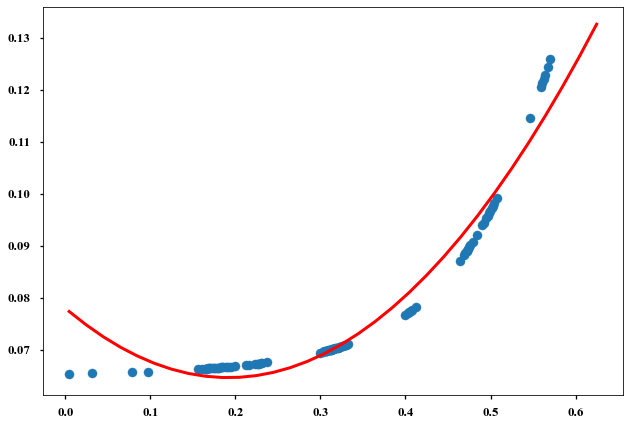

In [398]:
# alpha_avg 다항회귀
X = np.c_[df_rdcp.loc[:99,'rdcp'], (df_rdcp.loc[:99,'rdcp'])**2]
y1 = df_rdcp.loc[:99,'alpha_avg']
y2 = df_rdcp.loc[:99, 'gamma_avg']

# 선형 모델
model1 = LinearRegression()
model1.fit(X, y1)
model2 = LinearRegression()
model2.fit(X, y2)

model1.coef_[0], model1.intercept_

xs = np.arange(min(df_rdcp.rdcp),max(df_rdcp.rdcp),0.02) # x 범위의 순차값 생성
ys = xs*model2.coef_[0] + (xs**2)*model2.coef_[1] + model2.intercept_
# 2차 다항식 회귀

plt.scatter(df_rdcp.loc[:,'rdcp'], df_rdcp.loc[:,'gamma_avg'], alpha=1)
plt.plot(xs,ys,'r-',lw=3)